In [1]:
# more complex task:

# create a synthetic regression task:

def func_form(input_x):
    return np.cos(7*input_x+0.5) + 3 * input_x - 0.4 * (input_x+0.5)**3

def cognitive_bottleneck_comparison(y1, y2, beta):
    thres = np.exp(beta * (y1 - y2)) / (1 + np.exp(beta * (y1 - y2)))
    if np.random.rand() < thres:
        return 1
    else:
        return 0
VISUALIZE = False
XLIM =2
H1 = 100
H2 = 100
# LOCAL_THRES = 0.1

macro_out_list = []
for REP_MACRO in range(30):
    final_out_dict = {}
    for BETA in [1.0, 10.0]:
        final_out_dict[BETA] = {}
        for LOCAL_THRES in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            print(f"REP_MACRO {REP_MACRO} BETA {BETA} LOCAL_THRES {LOCAL_THRES}")
            final_out_dict[BETA][LOCAL_THRES] = {}
            import numpy as np
            import matplotlib.pyplot as plt

            out_dict = {}
            for N_EPOCH in [50]: #

                out_dict[N_EPOCH] = {}
                final_out_dict[BETA][LOCAL_THRES][N_EPOCH] = {}
                if VISUALIZE:
                    fig, axes = plt.subplots(4, 4, figsize=(40, 40))
                for j, N_SAMPLE in enumerate([50, 100, 1000, 3000]):
                    for k, N_COMPARE in enumerate([50, 100, 1000, 3000]):
                        out_dict[N_EPOCH][str((N_SAMPLE, N_COMPARE))] = {}
                        final_out_dict[BETA][LOCAL_THRES][N_EPOCH][str((N_SAMPLE, N_COMPARE))] = {}
                        if VISUALIZE:
                            ax = axes[j, k]

                        X = np.random.rand(N_SAMPLE, 1) * XLIM
                        # y = 2 + 3 * X + np.random.randn(N_SAMPLE, 1)
                        y =  func_form(X)

                        #normalize y to 0-1
                        # ymax = y.max()
                        # ymin = y.min()

                        # y = (y - y.min()) / (y.max() - y.min())
                        # y = (y - y.mean())  / y.std()

                        # plt.plot(X, y, "b.")
                        # plt.xlabel("$x$", fontsize=18)
                        # plt.ylabel("$y$", rotation=0, fontsize=18)
                        # draw the true line after normalization
                        # plt.plot(X, (2 + 3 * X - ymin)/(ymax-ymin), "r")


                        # create the pairwise dataset by randomly pick two for comparison:



                        pairwise_dataset = []
                        pairwise_label = []
                        while len(pairwise_dataset) < N_COMPARE:
                            # locally sample pairwise data
                            idx1 = np.random.randint(0, N_SAMPLE)
                            idx2 = np.random.randint(0, N_SAMPLE)
                            if np.abs(X[idx1] - X[idx2]) > LOCAL_THRES:
                                continue
                            pairwise_dataset.append((X[idx1].item(), X[idx2].item()))
                            # pairwise_label.append(1 if y[idx1] > y[idx2] else 0)
                            pairwise_label.append(cognitive_bottleneck_comparison(y[idx1], y[idx2], BETA))
                        # for i in range(N_COMPARE):
                        #     # locally sample pairwise data
                        #     while
                        #     idx1 = np.random.randint(0, N_SAMPLE)
                        #     idx2 = np.random.randint(0, N_SAMPLE)
                        #     pairwise_dataset.append((X[idx1].item(), X[idx2].item()))
                        #     pairwise_label.append(1 if y[idx1] > y[idx2] else 0)

                        pairwise_dataset = np.array(pairwise_dataset)
                        pairwise_label = np.array(pairwise_label)



                        clf_dataset = []
                        clf_label = []
                        for i, (x1, x2) in enumerate(pairwise_dataset):
                            if pairwise_label[i] == 1:
                                clf_dataset.append(x1)
                                clf_label.append(1)
                                clf_dataset.append(x2)
                                clf_label.append(0)
                            else:
                                clf_dataset.append(x1)
                                clf_label.append(0)
                                clf_dataset.append(x2)
                                clf_label.append(1)

                        clf_dataset = np.array(clf_dataset).reshape(-1, 1)
                        clf_label = np.array(clf_label)

                        # flip the pairwise data to augment the dataset
                        pairwise_dataset = np.vstack([pairwise_dataset, pairwise_dataset[:, ::-1]])
                        pairwise_label = np.hstack([pairwise_label, 1 - pairwise_label])




                        # logistic regression
                        from sklearn.linear_model import LogisticRegression
                        from sklearn.model_selection import train_test_split



                        X_train, X_test, y_train, y_test = train_test_split(clf_dataset, clf_label, test_size=0.2)
                        X_train_siamese, X_test_siamese, y_train_siamese, y_test_siamese = train_test_split(pairwise_dataset, pairwise_label, test_size=0.2)
                        # train tree based model
                        import lightgbm as lgb

                        lgb_train = lgb.Dataset(X_train, y_train)
                        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

                        lgb_model = lgb.train({'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1}, lgb_train, valid_sets=lgb_eval, num_boost_round=1000)

                        y_pred_lgb = lgb_model.predict(X_test)
                        y_pred_lgb = (y_pred_lgb > 0.5).astype(int)

                        # print("Train accuracy: ", log_reg.score(X_train, y_train))
                        # print("Test accuracy: ", log_reg.score(X_test, y_test))

                        # mlp model
                        from networks import MLP, forward_mlp, forward_siamese, train_model
                        import torch
                        import torch.optim as optim
                        import torch.nn as nn

                        X_train = torch.tensor(X_train, dtype=torch.float32)
                        X_test = torch.tensor(X_test, dtype=torch.float32)
                        y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
                        y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

                        X_train_siamese = torch.tensor(X_train_siamese, dtype=torch.float32).unsqueeze(-1)
                        X_test_siamese = torch.tensor(X_test_siamese, dtype=torch.float32).unsqueeze(-1)
                        y_train_siamese = torch.tensor(y_train_siamese, dtype=torch.float32).unsqueeze(1)
                        y_test_siamese = torch.tensor(y_test_siamese, dtype=torch.float32).unsqueeze(1)

                        mlp = MLP(1, H1, H2)
                        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                        train_model(mlp, device, 'clf', X_train, y_train, X_test, y_test, N_EPOCH, 0.001)

                        # eval the model
                        mlp.eval()
                        y_logits = forward_mlp(mlp, X_test)
                        y_logits = y_logits.detach().numpy()
                        y_pred = (y_logits > 0.5).astype(int)
                        # print("Test accuracy CLF: ", np.mean(y_pred == y_test.numpy()))

                        bt = MLP(1, H1, H2)
                        train_model(bt, device, 'siamese', X_train_siamese, y_train_siamese, X_test_siamese, y_test_siamese, N_EPOCH, 0.001)
                        bt.eval()
                        y_logits_bt = forward_siamese(bt, X_test_siamese[:, 0], X_test_siamese[:, 1])
                        y_logits_bt = y_logits_bt.detach().numpy()
                        y_pred_bt = (y_logits_bt > 0.5).astype(int)
                        # print("Test accuracy BT: ", np.mean(y_pred_bt == y_test_siamese.numpy()))





                        if VISUALIZE:
                            # predict the probability of any given data
                            X_new = np.linspace(0, XLIM, 1000).reshape(-1, 1)
                            # y_proba = log_reg.predict_proba(X_new)
                            y_mlp_logits = mlp(torch.tensor(X_new, dtype=torch.float32)).detach().numpy()
                            y_bt_logits = bt(torch.tensor(X_new, dtype=torch.float32)).detach().numpy()


                            # plt.plot(X_train, y_train, "b.")
                            # plt.plot(X_test, y_test, "g.")
                            ax.scatter(X, y, c='gray',alpha=0.3)
                            ax.set_xlabel("$x$", fontsize=18)
                            ax.set_ylabel("$y$", rotation=0, fontsize=18)
                            # draw the true line after normalization

                            line_dots = np.linspace(0, XLIM, 1000).reshape(-1, 1)
                            ax.plot(line_dots, func_form(line_dots), "r", label="True")
                            # draw the true functional curve

                            ax.plot(X_new, y_proba[:, 1], "g-", label="CLF - Logistic Regression")
                            ax.plot(X_new, y_mlp_logits, "b-", label="CLF - MLP")
                            ax.plot(X_new, y_bt_logits, "c-", label="BT - MLP")
                            ax.set_title(f"N_SAMPLE = {N_SAMPLE}, N_COMPARE = {N_COMPARE} EPOCH = {N_EPOCH} Diversity {LOCAL_THRES} Beta {BETA}")
                            ax.legend()
                            # plt.show()




                        # using best of N to evaluate the proxy reward models
                        bon_mlp_list = []
                        bon_bt_list = []
                        bon_lgb_list = []
                        for repeat in range(10):
                            mlp_temp_list = []
                            bt_temp_list = []
                            lgb_temp_list = []
                            for bon_n in [2, 5, 10, 50, 100, 300, 500]:
                                X_bon = np.random.rand(bon_n, 1) * XLIM
                                y_bon = func_form(X_bon) #+ np.random.randn(bon_n, 1)

                                # use different reward model to evaluate the performance
                                # 1. logistic regression
                                y_bon_mlp_logits = mlp(torch.tensor(X_bon, dtype=torch.float32)).detach().numpy()
                                y_bon_bt_logits = bt(torch.tensor(X_bon, dtype=torch.float32)).detach().numpy()
                                y_bon_lgb_logits = lgb_model.predict(X_bon)
                                # argmax the reward model
                                mlp_argmax_score = y_bon[np.argmax(y_bon_mlp_logits)]
                                bt_argmax_score = y_bon[np.argmax(y_bon_bt_logits)]
                                lgb_argmax_score = y_bon[np.argmax(y_bon_lgb_logits)]
                                # print(f"best of {bon_n} CLF argmax: {mlp_argmax_score}, BT argmax: {bt_argmax_score}")
                                mlp_temp_list.append(mlp_argmax_score.item())
                                bt_temp_list.append(bt_argmax_score.item())
                                lgb_temp_list.append(lgb_argmax_score.item())
                            bon_mlp_list.append(mlp_temp_list)
                            bon_bt_list.append(bt_temp_list)
                            bon_lgb_list.append(lgb_temp_list)


                        out_dict[N_EPOCH][str((N_SAMPLE, N_COMPARE))]['clf-bon-'] = bon_mlp_list
                        out_dict[N_EPOCH][str((N_SAMPLE, N_COMPARE))]['bt-bon-'] = bon_bt_list
                        out_dict[N_EPOCH][str((N_SAMPLE, N_COMPARE))]['lgb-bon-'] = bon_lgb_list
                        final_out_dict[BETA][LOCAL_THRES][N_EPOCH][str((N_SAMPLE, N_COMPARE))]['clf-bon'] = np.asarray(bon_mlp_list).mean(0)[-1]
                        final_out_dict[BETA][LOCAL_THRES][N_EPOCH][str((N_SAMPLE, N_COMPARE))]['bt-bon'] = np.asarray(bon_bt_list).mean(0)[-1]
                        final_out_dict[BETA][LOCAL_THRES][N_EPOCH][str((N_SAMPLE, N_COMPARE))]['lgb-bon'] = np.asarray(bon_lgb_list).mean(0)[-1]
                        if VISUALIZE:
                            x_list = np.arange(7) * 0.16
                            # use dual axis to plot the distribution of the best of N
                            ax2 = ax.twinx()
                            ax2.plot(x_list, np.mean(bon_mlp_list, 0), color = 'orange')
                            ax2.errorbar(x_list, np.mean(bon_mlp_list, 0), yerr=np.std(bon_mlp_list, 0), fmt='o', color='orange')
                            ax2.plot(x_list, np.mean(bon_bt_list, 0), color='black')
                            ax2.errorbar(x_list, np.mean(bon_bt_list, 0), yerr=np.std(bon_bt_list, 0), fmt='o', color='black')
                            ax2.set_ylabel("Golden Score Best of N", fontsize=18)
                            ax2.set_ylim(-4, 4)
                            ax2.legend(['CLF', 'BT'])


                # plt.savefig(f"synthetic_{N_EPOCH}_diverse_beta{BETA}.png", dpi=300, bbox_inches='tight')
                if VISUALIZE:
                    plt.show()

    macro_out_list.append(final_out_dict)

REP_MACRO 0 BETA 1.0 LOCAL_THRES 0.1
REP_MACRO 0 BETA 1.0 LOCAL_THRES 0.2


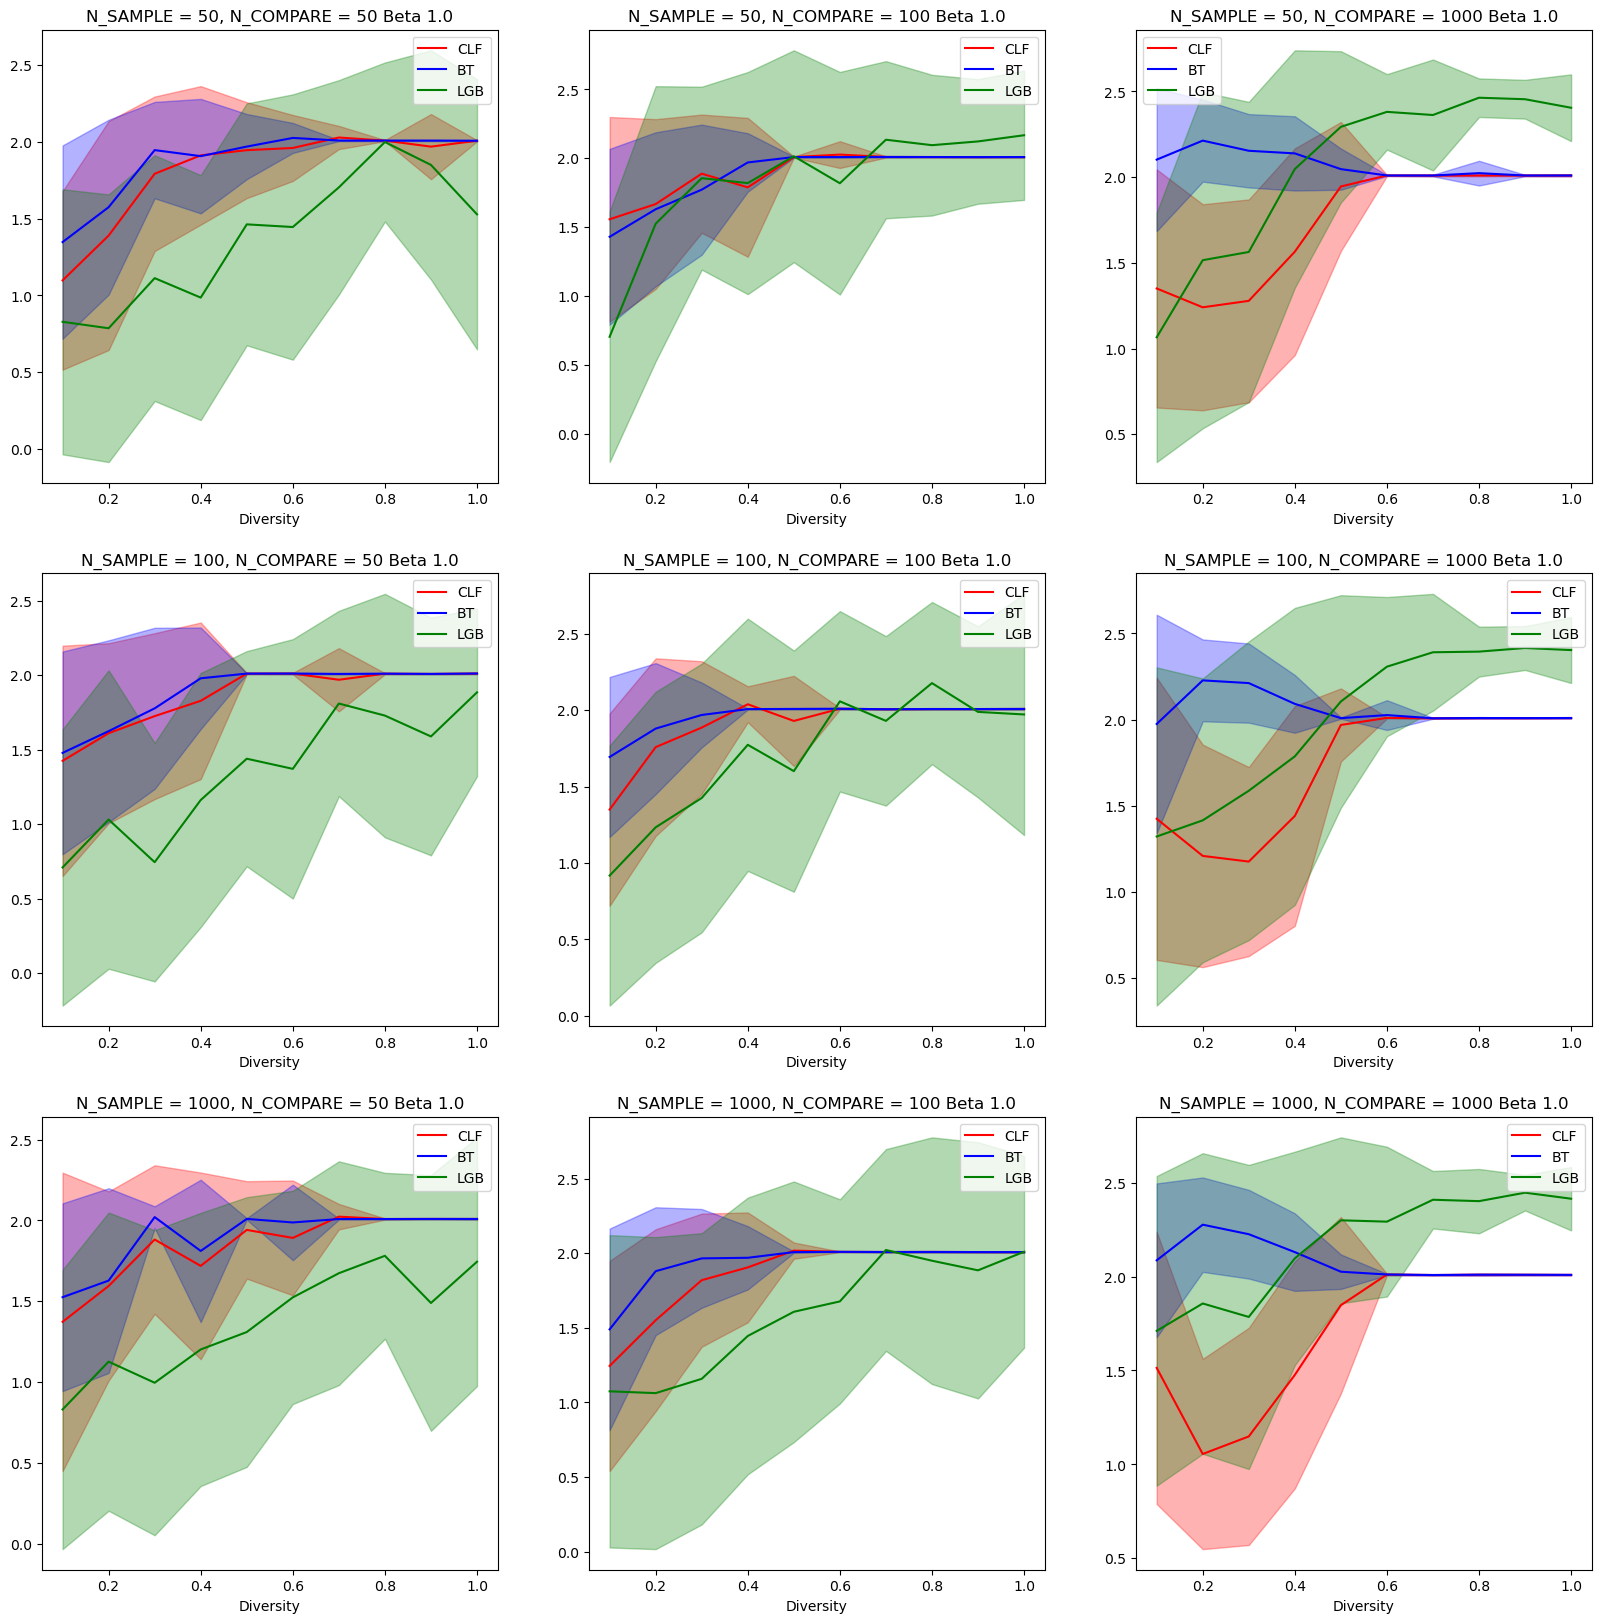

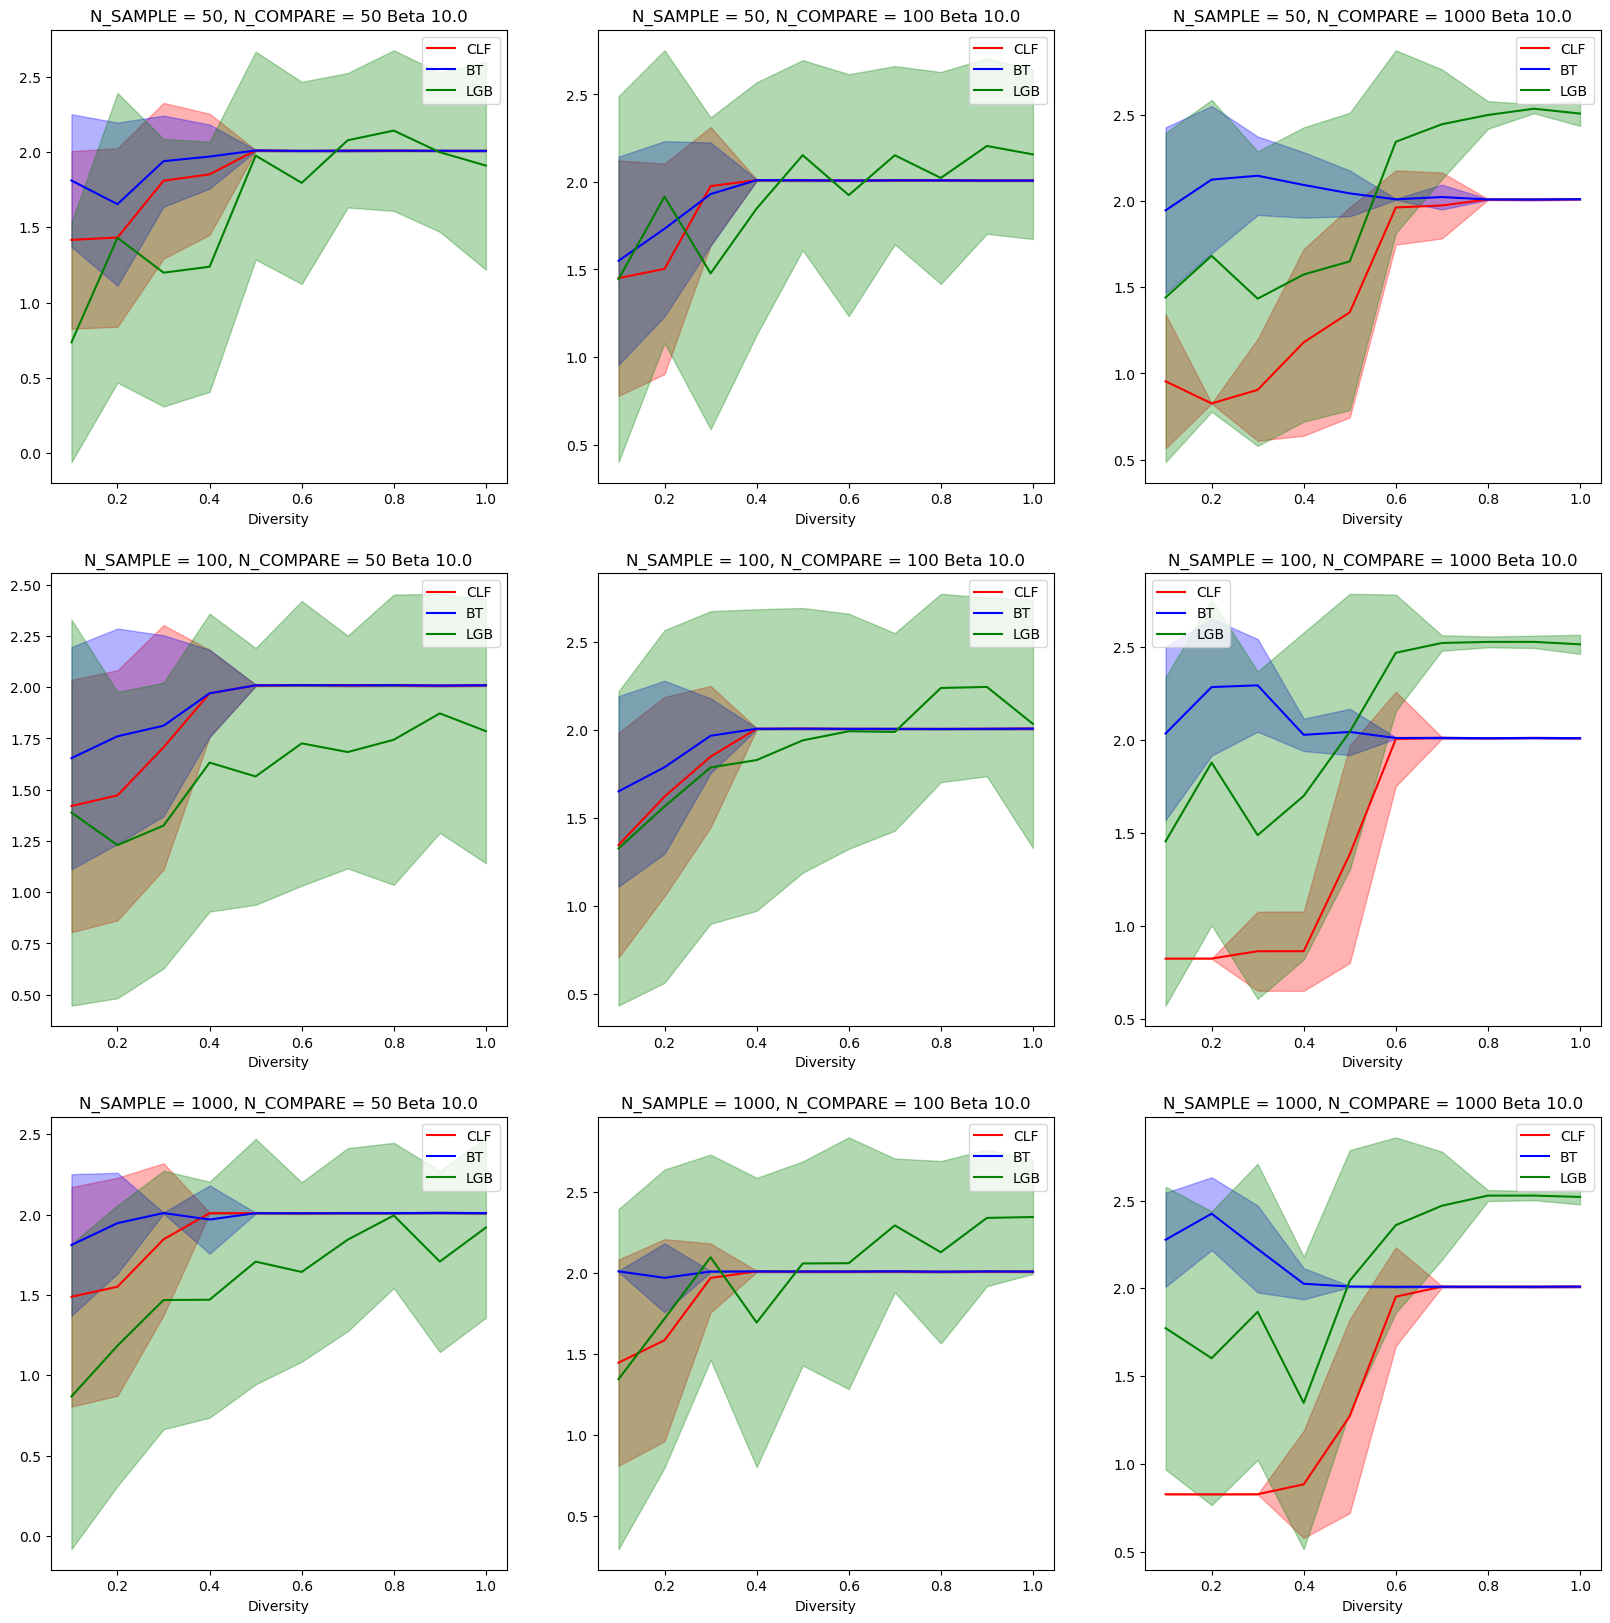

In [ ]:

for betavalue in [1.0, 10.0]:
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    idexer = 0
    for i in [50, 100, 1000]:
        for j in [50, 100, 1000]:
            ax = axes[idexer//3, idexer%3]
            idexer += 1
            list_of_clf_list = []
            list_of_bt_list = []
            list_of_lgb_list = []
            for REPEAT in range(30):
                clf_list = []
                bt_list = []
                lgb_list = []
                for k in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
                    clf_list.append(macro_out_list[REPEAT][betavalue][k][50][str((i, j))]['clf-bon'])
                    bt_list.append(macro_out_list[REPEAT][betavalue][k][50][str((i, j))]['bt-bon'])
                    lgb_list.append(macro_out_list[REPEAT][betavalue][k][50][str((i, j))]['lgb-bon'])
                list_of_clf_list.append(clf_list)
                list_of_bt_list.append(bt_list)
                list_of_lgb_list.append(lgb_list)
            final_clf_list = np.mean(list_of_clf_list, 0)
            final_bt_list = np.mean(list_of_bt_list, 0)
            final_clf_std = np.std(list_of_clf_list, 0)
            final_bt_std = np.std(list_of_bt_list, 0)
            final_lgb_list = np.mean(list_of_lgb_list, 0)
            final_lgb_std = np.std(list_of_lgb_list, 0)
            ax.plot(np.arange(1, 11)*0.1, final_clf_list, 'r', label='CLF')
            ax.fill_between(np.arange(1, 11)*0.1, final_clf_list - final_clf_std, final_clf_list + final_clf_std, color='r', alpha=0.3)
            ax.plot(np.arange(1, 11)*0.1, final_bt_list, 'b', label='BT')
            ax.fill_between(np.arange(1, 11)*0.1, final_bt_list - final_bt_std, final_bt_list + final_bt_std, color='b', alpha=0.3)
            ax.plot(np.arange(1, 11)*0.1, final_lgb_list, 'g', label='LGB')
            ax.fill_between(np.arange(1, 11)*0.1, final_lgb_list - final_lgb_std, final_lgb_list + final_lgb_std, color='g', alpha=0.3)

            ax.set_title(f"N_SAMPLE = {i}, N_COMPARE = {j} Beta {betavalue}")
            ax.set_xlabel("Diversity")
            ax.legend()
    plt.show()


In [28]:

# XLIM =1
# H1 = 50
# H2 = 50
# # LOCAL_THRES = 0.1

# macro_out_list = []
# for REP_MACRO in range(30):
#     final_out_dict = {}
#     for BETA in [1.0, 10.0]:
#         final_out_dict[BETA] = {}
#         for LOCAL_THRES in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#             print(f"REP_MACRO {REP_MACRO} BETA {BETA} LOCAL_THRES {LOCAL_THRES}")
#             final_out_dict[BETA][LOCAL_THRES] = {}
#             import numpy as np
#             import matplotlib.pyplot as plt

#             out_dict = {}
#             for N_EPOCH in [50]: #

# save to json file
import json
import os
os.makedirs('macro_out', exist_ok=True)
for REP_MACRO in range(30):
    with open(f'macro_out/macro_out_{REP_MACRO}_epoch{N_EPOCH}_nonlinearity-{XLIM}.json', 'w') as f:
        json.dump(macro_out_list[REP_MACRO], f)

In [19]:
len(macro_out_list)

30

In [22]:
str((N_SAMPLE, N_COMPARE))

'(1000, 1000)'